In [1]:
from tqdm import tqdm
import json
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import wordnet as wn
from copy import deepcopy
import re

In [2]:
stone_id = "3"
# harry potter and the sorcerer's stone = 3
# twilight = 41865

In [3]:
def get_reviews_from_book_id(book_id):
    reviews = []
    with open("data/goodreads_reviews_fantasy_paranormal.json") as f:
        for line in tqdm(f):
            review = json.loads(line)
            if review["book_id"] == book_id:
                reviews.append(review)
    return reviews

reviews = get_reviews_from_book_id(stone_id)

3424641it [01:10, 48876.68it/s]


In [46]:
def get_ids():
    ids = set()
    with open("data/goodreads_reviews_fantasy_paranormal.json") as f:
        for line in tqdm(f):
            review = json.loads(line)
            ids.add(review["book_id"])
    return ids

3424641it [00:53, 64235.86it/s]


In [4]:
lemmatizer = WordNetLemmatizer()
text = " ".join(review["review_text"] for review in reviews)
tokenized = nltk.word_tokenize(text)
possed = nltk.pos_tag(tokenized)

In [5]:
lemmatized = [lemmatizer.lemmatize(word, pos.lower()[0] if pos.lower()[0] in "nvars" else "n").lower() for word, pos in possed]

In [6]:
fd = nltk.FreqDist(lemmatized)
sia = SentimentIntensityAnalyzer()

In [7]:
def sentimental_words(fd, total, treshold):
    count = 0
    result = []
    for val, freq in fd.most_common():
        scores = sia.polarity_scores(val)
        if abs(scores["compound"]) > treshold:
            result.append((val, freq, scores))
            count += 1
        if count > total:
            break
    return result

In [8]:
sentimental_words(fd, 20, 0.6)

[('love', 3249, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6369}),
 ('great', 1161, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6249}),
 ('best', 563, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6369}),
 ('awesome', 270, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6249}),
 ('evil', 227, {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.6597}),
 ('kill', 158, {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.6908}),
 ('perfectly', 73, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6369}),
 ('greatest', 62, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6369}),
 ('hell', 54, {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.6808}),
 ('worst', 39, {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.6249}),
 ('masterpiece', 33, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6249}),
 ('abuse', 33, {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.6369}),
 ('dead', 32, {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.6486}),
 ('lovable', 29

In [9]:
import spacy
from spacy import displacy
import en_core_web_md

2022-05-04 21:32:11.411839: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-04 21:32:11.411871: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [10]:
nlp = en_core_web_md.load()

In [11]:
nlp.max_length = len(text)

In [12]:
print(len(text))
print(len(text.split()))

3033929
558007


In [13]:
doc = nlp(text)

In [14]:
people = [ent for ent in doc.ents if ent.label_ == "PERSON"]

In [15]:
fdp = nltk.FreqDist(ent.text for ent in people)

In [51]:
# fdp.most_common(20)

In [17]:
def no_unsquishables(needle, haystack, unsquishables):
    for h in haystack:
        if h in unsquishables and h not in needle:
            return False
    return True

def is_word_aware_infix(needle, haystack, unsquishables):
    needle = re.split("[^a-zA-Z]+", needle.lower())
    haystack = re.split("[^a-zA-Z]+", haystack.lower())
    for i in range(len(haystack) - len(needle) + 1):
        if needle == haystack[i:i+len(needle)] and no_unsquishables(needle, haystack, unsquishables):
            return True        
    return False

def contained_in(needle_half, haystack, unsquishables):
    result = set()
    for hay in haystack:
        if needle_half != hay and is_word_aware_infix(needle_half, hay, unsquishables):
            result.add(hay)
    return result

def propagate(mapping):
    for from_, to_ in mapping.items():
        current = mapping[from_]
        stack = [from_]
        while current != mapping[to_]:
            stack.append(current)
            current = mapping[to_]
        for item in stack:
            mapping[item] = current
    return mapping

def squish(values, unsquishables=set()):
    unprocessed = set(values)

    mapping = {val:val for val in values}
    for val in values:
        if val not in unprocessed:
            continue
        for con in contained_in(val, unprocessed, unsquishables):
            mapping[con] = val
            unprocessed.remove(con)
            
    return propagate(mapping)

def squish_chars(people, count=20):
    fdp = nltk.FreqDist(ent.text for ent in people)
    names = [p[0] for p in fdp.most_common(count)]
    return squish(names)

names_mapping = squish_chars(people)

In [49]:
# names_mapping

In [50]:
# sorted(
#     ((dec, sum(fdp.get(name) for name in names_mapping if names_mapping[name] == dec))
#     for dec in set(names_mapping.values())),
#     key=lambda pair: pair[1],
#     reverse=True
# )

In [21]:
sia = SentimentIntensityAnalyzer()
for word in doc.vocab:
    scores = sia.polarity_scores(word.text)
    doc.vocab[word.text].sentiment = scores["compound"]

In [22]:
def get_dependent(token, dependencies, deep=False):
    return [word for word in (token.subtree if deep else token.children) if word.dep_ in dependencies]

def get_dependent_leveled(token, dependencies):
    to_process = list(token.children)
    result = []
    while to_process:
        child = to_process.pop(0)
        if child.dep_ in dependencies:
            result.append(child)
        else:
            to_process.extend(child.children)
    return result

def get_dependent_passthrough(token, dependencies, passthroughs, result = None):
    result = result if result is not None else []
    for child in token.children:
        if child.dep_ in dependencies:
            result.append(child)
        if child.dep_ in passthroughs:
            get_dependent_passthrough(child, dependencies, passthroughs, result)
    
    return result

def get_dependent_passthrough_note(token, dependencies, passthroughs, note, result = None):
    result = result if result is not None else []
    for child in token.children:
        if child.dep_ in dependencies:
            result.append(child)
        elif child.dep_ in passthroughs:
            if child.dep_ in note:
                result.append(child)
            get_dependent_passthrough(child, dependencies, passthroughs, result)
    return result
        

def dic_add(dic, keys, vals):
    str_key = " ".join(key.text for key in keys).lower()
    if str_key not in dic:
        dic[str_key] = {
            "nouns" : keys,
            "adjs" : []
        }
    adjs = dic[str_key]["adjs"]
    adjs.append(vals)
    
def dic_add_single(dic, key, vals):
    str_key = key.text
    
    if str_key not in dic:
        dic[str_key] = {
            "nouns" : key,
            "adjs" : []
        }
    adjs = dic[str_key]["adjs"]
    adjs.append(vals)

In [23]:
def get_what(parent):
    what = []
    if not what:
        what = get_dependent_passthrough(parent, ["acomp"], ["xcomp"])
    if not what:
        what = get_dependent(parent, ["attr"])
    if not what:
        what = get_dependent_passthrough(parent, ["pobj"], ["prep"])
    if not what or what[0].pos_ == "PRON":
        return []
    return what


def get_negs(parent, what, old_negs=None):
    negs = []
    if not negs:
        negs = get_dependent(parent, ["neg"])
    if not negs:
        negs = [det for det in get_dependent(what, ["det"]) if det.text.strip().lower() == "no"]
    if not negs:
        return old_negs if old_negs is not None else []
    return negs


def get_mods(what, start=None):
    preps = [what.head] if what.head.dep_ == "prep" and what.head.head == start else []
    mods = get_dependent_passthrough(what, ["amod", "compound", "advmod", "nummod", "npadvmod"], ["amod", "compound", "npadvmod"])
    if not mods and what.dep_ not in ["pobj", "prep"]:
        mods = get_dependent_passthrough(what, ["pobj", "prep"], ["prep"])
    else:
        mods = [mod for mod in mods if mod.i < what.i]
    mods = [mod for mod in mods if (start is None or mod.i > start.i) and mod.pos_ != "SCONJ"]
    return preps + mods


def get_adj_mods(what, start=None):
    mods = get_mods(what, start)
    return [mod for mod in mods if mod.pos_ in ["ADJ", "NOUN"] and mod.i < what.i]


def get_description_from_mods(token):
    return [[mod] for mod in get_adj_mods(token)]


def get_description_from_aux(token, aux):
    whats = get_what(aux)
    if not whats:
        return []

    result = []
    negs = get_negs(aux, whats[0])
    while whats:
        if len(whats) > 1:
            result.append(whats)
            break
        
        what = whats[0]
        mods = get_mods(what, aux)
        desc = sorted(negs + mods + [what], key=lambda tok: tok.i)
        result.append(desc)
    
        whats = get_dependent(what, ["conj"])
    
    return result

def get_description(token):
    descs = get_description_from_mods(token)
    if descs:
        return descs

    while token.dep_ == "conj":
        token = token.head

    if token.dep_ == "nsubj" and token.head.pos_ == "AUX":
        return get_description_from_aux(token, token.head)
    return []

def get_character_descriptions(people, verbose=False):
    result = {}
    for i, person in enumerate(people):
        if person.text not in names_mapping:
            continue
        word = person.root
        descs = get_description(word)

        if descs and verbose:
            parent = word.head if word.head.pos_ == "AUX" else None
            print(i)
            for desc in descs:
                print("  ", person, parent if parent is not None else "is", *desc)
            print(" ".join(word.text for word in (parent.subtree if parent is not None else word.subtree)))
            print()
        
        key = names_mapping[person.text]
        old_descs = result.get(key, [])
        old_descs.extend(descs)
        result[key] = old_descs
    
    return result

def get_aspect_descriptions(doc, aspects, verbose=False):
    result = {}
    for word in doc:
        if word.text not in aspects:
            continue
        
        descs = get_description(word)
        
        if descs and verbose:
            parent = word.head if word.head.pos_ == "AUX" else None
            print(i)
            for desc in descs:
                print("  ", person, parent if parent is not None else "is", *desc)
            print(" ".join(word.text for word in (parent.subtree if parent is not None else word.subtree)))
            print()
        
        key = word.text
        old_descs = result.get(key, [])
        old_descs.extend(descs)
        result[key] = old_descs
    return result

character_descriptions = get_character_descriptions(people)
aspect_descriptions = get_aspect_descriptions(doc, ["book", "story", "building", "pacing", "characters"])

In [24]:
# i = 1775 # 602, 784
# print(people[i].sent)
# displacy.render(people[i].sent)


 You also have the wise and quiet Dumbledore, the stern McGonagall, the scary Filch, and the cruel and sinister Snape.


Harry 624 

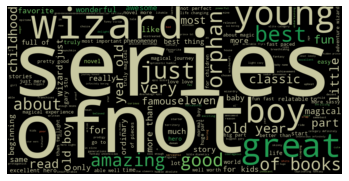

never prejudiced against slytherin
fast paced adventure thrill ride
best tasting healthy brainfood
sweetest most delightful peice
just pitiful helpless preteen
completely different journey
most successful book series

Rowling 207 

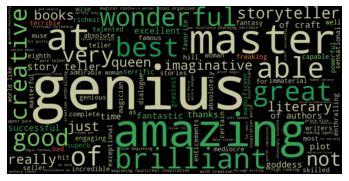

absolutely brilliant storyteller
really excellent storyteller
incredibly creative writer
soft spoken story teller
wizard through writing
really talented writer
writer par excellence

Ron 92 

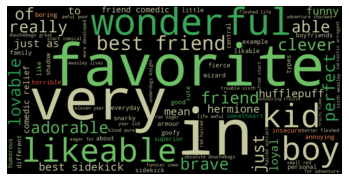

horrible to about hermione
very lovable characters
really cute character
wonderful characters
very good hufflepuff
eleven year old boys
likeable from start

Hermione 58 

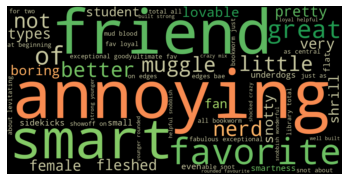

great female character
snot about levitating
annoying at beginning
very smart character
favourite character
not fan of library
favorite character

Dumbledore 53 

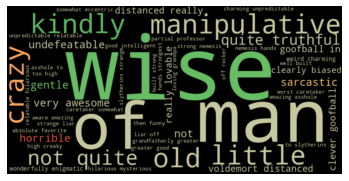

charming unpredictable relatable
off rocker crazy old man-
manipulative horrible man
enigmatic manipulative
somewhat eccentric man
very awesome character
asshole to slytherins

Hogwarts 41 

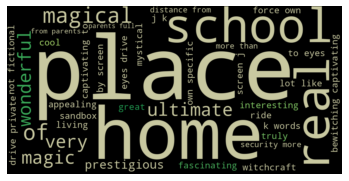

wonderful magical ride
very fascinating place
very interesting place
distance from parents
school of witchcraft
truly magical place
not fictional place

Voldemort 37 

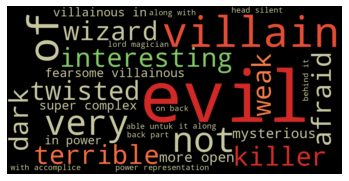

one behind it along with accomplice
not very interesting villain
super complex characters
representation of evil
twisted evil lord
evil character
so mysterious

Jim Dale 30 

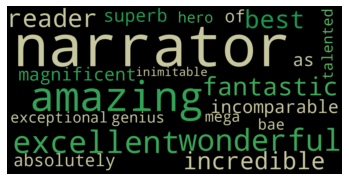

absolutely fantastic narrator
mega talented narrator
as wonderful narrator
incredible narrator
wonderful narrator
excellent narrator
amazing narrator

Dursleys 23 

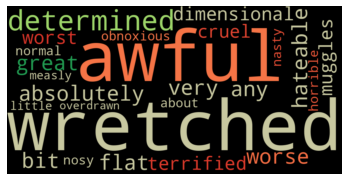

absolutely great characters
little overdrawn
one dimensional
very hateable
determined
terrified
obnoxious

Neville 19 

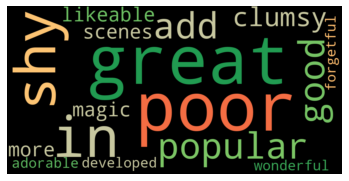

popular character
more developed
so likeable
forgetful
scenes in
wonderful
adorable

book 2803 

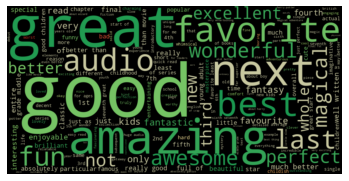

imaginative charming very british
not not accomplishment(because
well written magical adventure
antithetical to metamorphosis
totally different experience
start of everything for me
absolutely just as amazing

story 603 

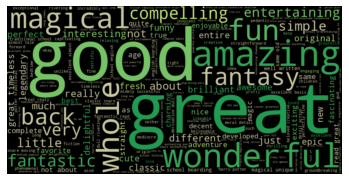

so plain spoken so straightforward
just so incredibly magical
from third person point
wonderfully imaginative
pretty straight forward
not about harry potter
defiantly page turning

characters 590 

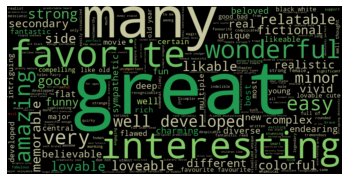

so strong especially draco
like old beloved friends
wonderful with virtues
effortlessly relatable
unique with exception
not interesting to me
totally uninteresting

building 108 

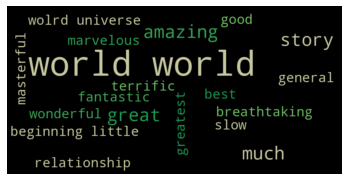

relationship
breathtaking
fantastic
wonderful
marvelous
character
masterful

pacing 15 

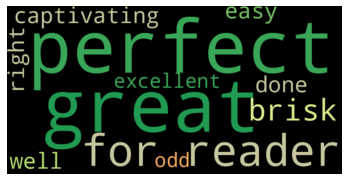

perfect for reader
captivating
excellent
well done
perfect
great
brisk



In [31]:
def word_to_color(word, *args, **kwargs):
    sentiment = doc.vocab[word].sentiment
    import matplotlib as mpl
    import matplotlib.cm as cm

    norm = mpl.colors.Normalize(vmin=-0.8, vmax=0.8)
    cmap = cm.RdYlGn

    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    color = tuple(map(lambda v: int(255*v), m.to_rgba(sentiment)[:3]))
    return color if color != (254, 254, 189) else (200, 200, 160)

def print_descriptions(descs, min_descs=15):
    forbidden = {"character", "characters", "one", "main", "first", "second", "writer", "author", "book", "so", "other"}
    for key, descs in sorted(descs.items(), key=lambda pair: len(pair[1]), reverse=True):
        descs = [" ".join(word.text if word.text != "n't" else "not" for word in desc).lower() for desc in descs]
        if len(descs) < min_descs:
            continue
#         squish_map = squish(descs, unsquishables={"not", "no", "n", "t"})

        print(key, len(descs), end=" ")
#         fd = nltk.FreqDist(descs)
#         print(len(squish_map.values()))
#         for val, freq in fd.most_common(100):
#             print(f"{val}: {freq}", end=", ")
#         print()
        
#         fd = nltk.FreqDist(squish_map[desc] for desc in descs)
#         for val, freq in fd.most_common(10):
#             print(f"{val}: {freq}", end=", ")
#         print()

        from wordcloud import WordCloud
        import matplotlib.pyplot as plt
    
        wordcloud = WordCloud(
            width=1200,
            height=600,
            stopwords=forbidden,
            collocation_threshold=10,
            color_func=word_to_color
        ).generate(" ".join(descs))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        
        print(*sorted(set(descs), key=len, reverse=True)[:7], sep="\n")

        print()

print_descriptions(character_descriptions)
print_descriptions(aspect_descriptions)

In [ ]:
for name, descs in character_descriptions.items():
    fd = nltk.FreqDist(" ".join(word.text for word in desc).lower() for desc in descs)
    print(name)
    print(*fd.most_common(10), sep="\n")
    print()

In [ ]:
for name, descs in aspect_descriptions.items():
    fd = nltk.FreqDist(" ".join(word.text for word in desc).lower() for desc in descs)
    print(name)
    print(*fd.most_common(10), sep="\n")
    print()

In [41]:
result_dic = {}
for word in doc:
    if abs(word.sentiment) < 0.6 or not word.pos_.startswith("A") or word.dep_ == "ROOT":
        continue

    parent = word.head
    key = word.text.lower()
    if word.dep_ == "amod":
        negs = get_dependent(word, ["neg"])
#             print("FST")
#             print(word.text, parent.text)
#             print(" ".join(word.text for word in parent.subtree))
#             print()
#         dic_add_single(result_dic, parent, negs + [word])
        old_desc = result_dic.get(key, [])
        old_desc.append(negs + [parent])
        result_dic[key] = old_desc
        continue
    subjs = get_dependent(parent, ["nsubj"])
    if subjs and subjs[0].pos_ not in ("PROP", "PRON", "PUNCT", "SCONJ"):
        if parent.pos_ == "AUX":
            amods = get_dependent(subjs[0], ["amod", "compound"], deep=True)
            negs = get_dependent(parent, ["neg"])
#                 print(word, end=" ")
#                 print(word.dep_, end=" ")
#                 print()
#                 print("SND")
#                 print(*amods, subjs[0], parent, *negs, word)
#                 print(" ".join(word.text for word in parent.subtree))
#                 print()
#             dic_add_single(result_dic, subjs[0], negs + [word])
            for amod in amods:
                old_desc = result_dic.get(key, [])
                old_desc.append(negs + [amod])
                result_dic[key] = old_desc
            continue
#         print(word, end=" ")
#         print(word.dep_)
#         print(" ".join(word.text for word in parent.subtree))
#         print(word.sent)
#         print()

great 875 

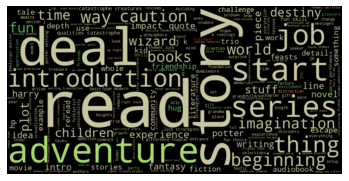

not literature
grandchildren
visualization
illustrations
accompaniment
literature"--
introduction

best 429 

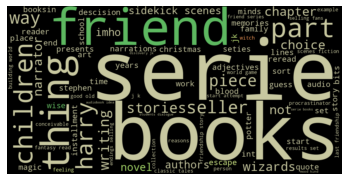

procrastinator
installment
not writing
conceivable
characters
narrations
friendship

awesome 119 

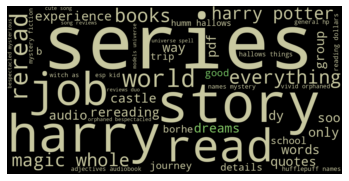

bespectacled
experience
hufflepuff
mysterious
adjectives
everything
rereading

evil 99 

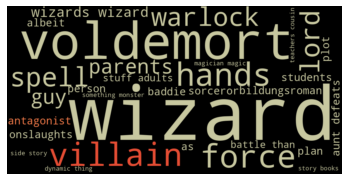

bildungsroman
antagonist)-
onslaughts
characters
something
voldemort
character

greatest 59 

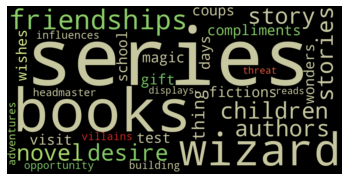

friendships
compliments
opportunity
adventures
headmaster
characters
influences

worst 23 

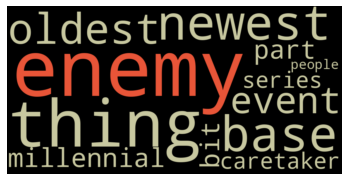

millennial
caretaker
people
series
newest
oldest
first

lovable 16 

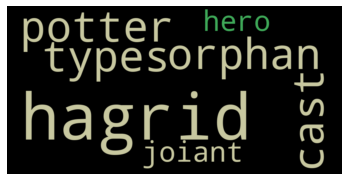

characters
character
orphan
potter
hagrid
joiant
types

superb 11 

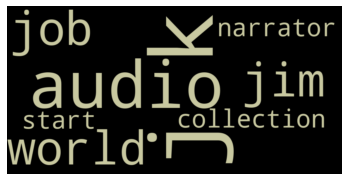

collection
narrator
audio
start
world
book
j.k.

abusive 11 

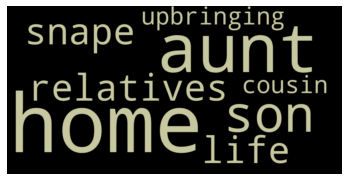

upbringing
relatives
cousin
snape
aunt
life
home

outstanding 10 

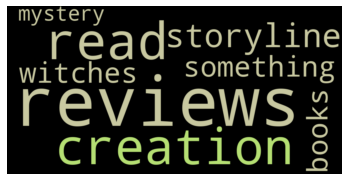

characters
something
storyline
creation
mystery
reviews
witches

dead 10 

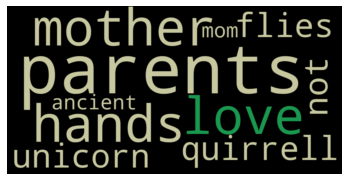

not ancient
quirrell
unicorn
parents
mother
hands
flies

gorgeous 8 

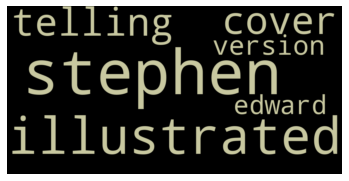

illustrated
character
version
telling
stephen
edward
cover



In [44]:
print_descriptions(result_dic, min_descs=5)

In [26]:
result = []
result_dic = {}
for word in doc:
    if abs(word.sentiment) > 0.6:
        if word.pos_.startswith("A"):
            if word.dep_ == "ROOT":
                continue
            parent = word.head
            if word.dep_ == "amod":
                negs = get_dependent(word, ["neg"])
    #             print("FST")
    #             print(word.text, parent.text)
    #             print(" ".join(word.text for word in parent.subtree))
    #             print()
                result.append([word, *negs, parent])
                dic_add_single(result_dic, parent, negs + [word])
                continue
            subjs = get_dependent(parent, ["nsubj"])
            if subjs and subjs[0].pos_ not in ("PROP", "PRON", "PUNCT", "SCONJ"):
                if parent.pos_ == "AUX":
                    amods = get_dependent(subjs[0], ["amod", "compound"], deep=True)
                    negs = get_dependent(parent, ["neg"])
    #                 print(word, end=" ")
    #                 print(word.dep_, end=" ")
    #                 print()
    #                 print("SND")
    #                 print(*amods, subjs[0], parent, *negs, word)
    #                 print(" ".join(word.text for word in parent.subtree))
    #                 print()
                    result.append(amods + [subjs[0], parent] + negs + [word])
                    dic_add_single(result_dic, subjs[0], negs + [word])
    #                 displacy.render(word.sent)
                    continue
                if word.dep_ == "advmod":
    #                 objs = get_dependent(parent, ["dobj"])
    #                 print(word, end=" ")
    #                 print(word.dep_, end=" ")
    #                 print()
    #                 print(subjs[0], parent, *objs, word)
    #                 print(subjs[0].pos_)
    #                 print(" ".join(word.text for word in parent.subtree))
    #                 print()
    #                 displacy.render(word.sent)
                    continue
#         print(word, end=" ")
#         print(word.dep_)
#         print(" ".join(word.text for word in parent.subtree))
#         print(word.sent)
#         print()

In [27]:
def subsequences(words, max_len, min_len=1):
    result = []
    for length in range(max_len, min_len - 1, -1):
        for start in range(len(words) - length + 1):
            result.append(words[start:start + length])
    return result

def pos(spacy_pos):
    if spacy_pos.startswith("N"):
        return wn.NOUN
    if spacy_pos.startswith("V"):
        return wn.VERB
    if spacy_pos == "ADJ":
        return wn.ADJ
    if spacy_pos == "ADV":
        return wn.ADV
    return None

def remap(mapping, old, new, v=0):
    if old == new:
        return
    if new not in mapping:
        mapping[new] = new
    while mapping[new] != new:
        new = mapping[new]
    if v:
        print(f"{old} -> {new}")
    mapping[old] = new

def squish_by_mapping(dic, mapping):
    new = {}
    for from_, to_ in mapping.items():
        if to_ in new:
            adjs = new[to_]
        elif to_ in dic:
            adjs = { "nouns" : dic[to_]["nouns"], "adjs" : dic[to_]["adjs"][:] }
        else:
            adjs = { "nouns" : None, "adjs" : []}
        
        if from_ in dic:
            adjs["adjs"].extend(dic[from_]["adjs"][:])
        new[to_] = adjs
    return new
    
def squish(dic):
    lemmatizer = WordNetLemmatizer()
    mapping = {key:key for key in dic.keys()}
#     for key in sorted(dic.keys(), key=lambda key: (key.count(" "), -len(dic[key]["adjs"]))):
#         split = key.split()
#         if len(split) < 2:
#             continue
#         mapped_subseqs = [
#             subseq for subseq in [" ".join(subseq) for subseq in subsequences(split, len(split) - 1)] if subseq in mapping
#         ]
#         if not mapped_subseqs:
#             continue
#         sorted_subseqs = sorted(mapped_subseqs, key=lambda key: len(dic[key]["adjs"]), reverse=True)
#         new = sorted_subseqs[0]
#         remap(mapping, key, new)
    for key in sorted(dic.keys(), key=lambda key: (key.count(" "), -len(dic[key]["adjs"]))):
        lemmatized = lemmatizer.lemmatize(key.lower())
        synsets = wn.synsets(lemmatized, pos=pos(dic[key]["nouns"].pos_))
        remap(mapping, key, lemmatized)
        if synsets:
            lemmas = set(str(lemma.name()) for lemma in synsets[0].lemmas())
            keys = set(dic.keys())
            intersect = lemmas & keys
            if intersect:
                new = max(intersect, key=lambda key: len(dic[key]["adjs"]))
                remap(mapping, key, new, v=0)
    return squish_by_mapping(dic, mapping)

squished = squish(result_dic)

In [28]:
print(len(result_dic))
print(len(squished))

439
355


In [29]:
foos = sorted(squished.items(), key=lambda it: len(it[1]["adjs"]), reverse=True)

book 585 

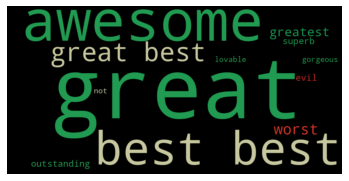

outstanding
not best
gorgeous
greatest
awesome
lovable
superb

series 221 

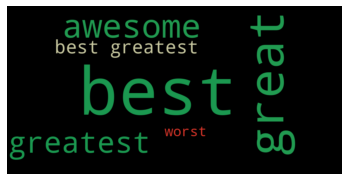

greatest
awesome
great
worst
best

story 142 

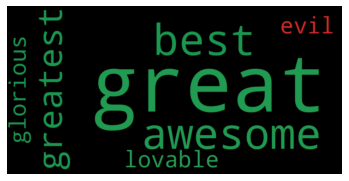

glorious
greatest
awesome
lovable
great
evil
best

read 135 

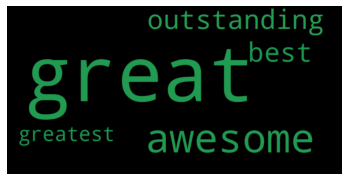

outstanding
greatest
awesome
great
best

wizard 87 

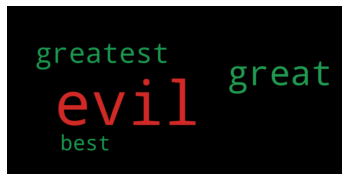

greatest
great
best
evil

thing 81 

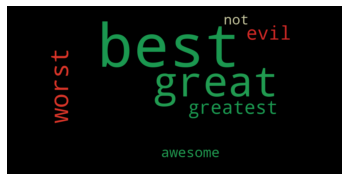

not great
greatest
awesome
great
worst
evil
best

deal 78 

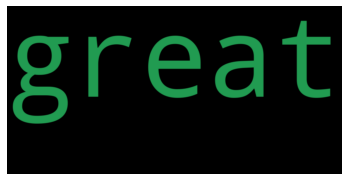

great

friend 73 

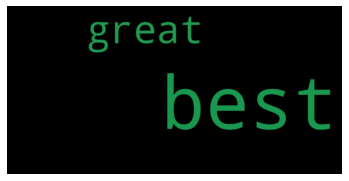

great
best

adventure 71 

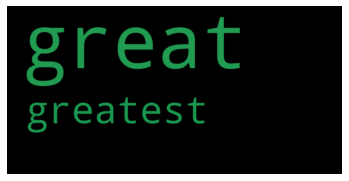

greatest
great

character 67 

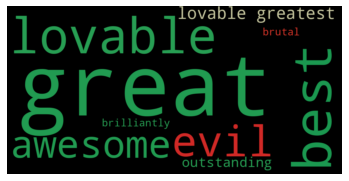

brilliantly
outstanding
greatest
awesome
lovable
brutal
great

start 67 

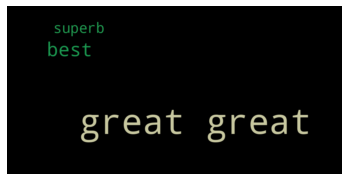

superb
great
best

job 52 

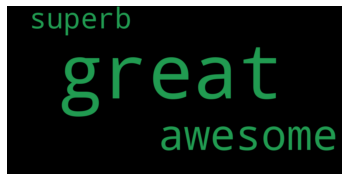

awesome
superb
great

introduction 48 

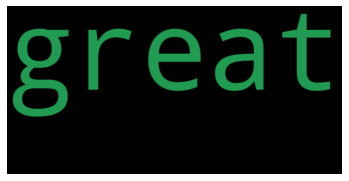

great

way 46 

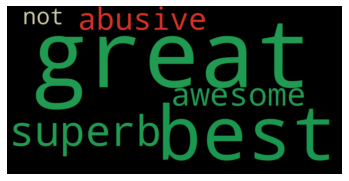

not best
awesome
abusive
superb
great
best

author 41 

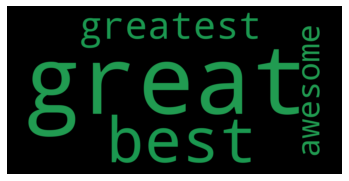

greatest
awesome
great
best

one 37 

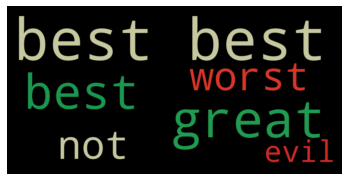

not best
great
worst
evil
best

writing 28 

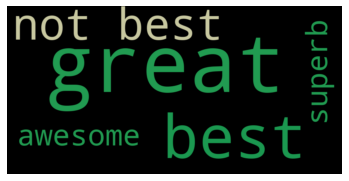

not best
awesome
superb
great
best

world 27 

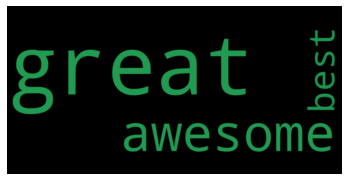

awesome
great
best

beginning 26 

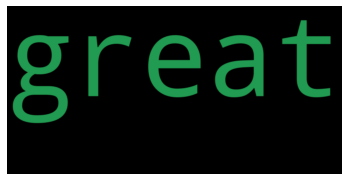

great

kid 24 

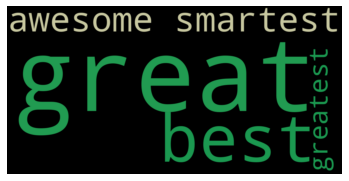

smartest
greatest
awesome
great
best

part 24 

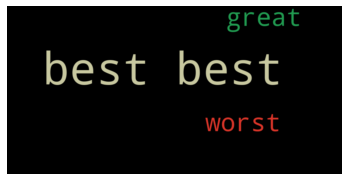

worst
great
best

caution 22 

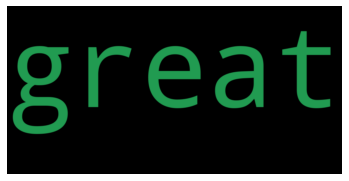

great

plot 20 

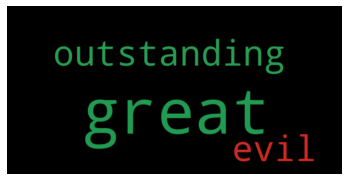

outstanding
great
evil

imagination 20 

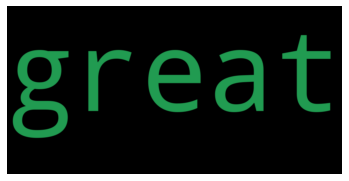

great

fun 18 

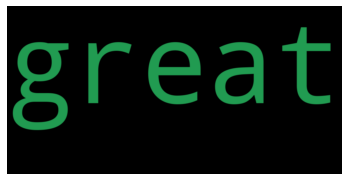

great

time 18 

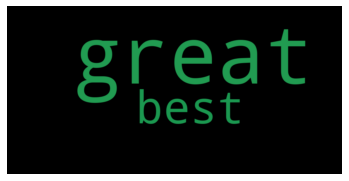

great
best

movie 18 

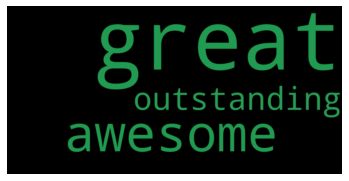

outstanding
awesome
great

novel 16 

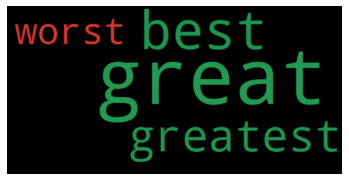

greatest
worst
great
best



In [36]:
print_descriptions({key:val["adjs"] for key, val in squished.items()})

In [30]:
for key, vals in foos:
    adjs = vals["adjs"]
    if len(adjs) <= 10:
        break
    fd = nltk.FreqDist([" ".join(word.text for word in span).lower() for span in adjs])
    print(key, len(adjs))
    print(fd.most_common(10))
    print()

book 585
[('great', 294), ('best', 176), ('awesome', 83), ('worst', 10), ('greatest', 7), ('outstanding', 3), ('superb', 3), ('evil', 3), ('lovable', 2), ('gorgeous', 2)]

series 221
[('best', 123), ('great', 56), ('awesome', 20), ('greatest', 20), ('worst', 2)]

story 142
[('great', 110), ('awesome', 10), ('best', 10), ('greatest', 6), ('evil', 2), ('glorious', 2), ('lovable', 2)]

read 135
[('great', 124), ('awesome', 6), ('outstanding', 2), ('best', 2), ('greatest', 1)]

wizard 87
[('evil', 68), ('great', 10), ('greatest', 6), ('best', 3)]

thing 81
[('best', 51), ('great', 20), ('worst', 4), ('greatest', 2), ('evil', 2), ('awesome', 1), ("n't great", 1)]

deal 78
[('great', 78)]

friend 73
[('best', 69), ('great', 4)]

adventure 71
[('great', 70), ('greatest', 1)]

character 67
[('great', 33), ('lovable', 10), ('best', 8), ('evil', 5), ('awesome', 4), ('greatest', 3), ('outstanding', 2), ('brutal', 1), ('brilliantly', 1)]

start 67
[('great', 61), ('best', 4), ('superb', 2)]

job 5